In [3]:
import os 
import subprocess
import torch 
import numpy as np
import math
import argparse
import pathlib
import h5py
import time
import matplotlib.pyplot as plt
import pickle
import json
from itertools import product

import warnings
warnings.filterwarnings('ignore')


In [4]:
from functions import load_position_h5, load_point_cloud_h5

# Récupération des Données et Visualisation

In [5]:
import os, subprocess

data_dir = "CosmoBench_CAMELS"
os.makedirs(data_dir, exist_ok=True)

base = "https://users.flatironinstitute.org/~fvillaescusa/CosmoBench/CAMELS/"
files = [
    "ALL_galaxies_train.hdf5",
    "ALL_galaxies_val.hdf5",
    "ALL_galaxies_test.hdf5",
]

for fname in files:
    url = base + fname
    out = os.path.join(data_dir, fname)
    if os.path.exists(out):
        print(f"Skip (exists): {out}")
        continue
    print(f"curl -> {out}")
    subprocess.run(["curl", "-L", "-o", out, url], check=True)

print("Done. Contents:", os.listdir(data_dir))



Skip (exists): CosmoBench_CAMELS\ALL_galaxies_train.hdf5
Skip (exists): CosmoBench_CAMELS\ALL_galaxies_val.hdf5
Skip (exists): CosmoBench_CAMELS\ALL_galaxies_test.hdf5
Done. Contents: ['ALL_galaxies_test.hdf5', 'ALL_galaxies_train.hdf5', 'ALL_galaxies_val.hdf5']


In [6]:
#specify the h5 file dataset group key
data_dir = "CosmoBench_CAMELS"

if "Quijote" in data_dir:
    grp_key = "BSQ"
elif "CAMELS" in data_dir:
    grp_key = "LH"
#train/val/test files
h5_train = f"{data_dir}/ALL_galaxies_train.hdf5"
h5_val = f"{data_dir}/ALL_galaxies_val.hdf5"
h5_test = f"{data_dir}/ALL_galaxies_test.hdf5"

In [7]:
## Transformations des .hdf5 en npy

with h5py.File(h5_train, "r") as f:
    # Afficher les datasets disponibles
    print("Clés dans le fichier :", list(f.keys()))

Clés dans le fichier : ['LH', 'original_ids', 'params']


In [8]:

with h5py.File(h5_train, "r") as f:
    def show(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"[DATASET] {name}  shape={obj.shape}  dtype={obj.dtype}")
        else:
            # obj est un Group
            try:
                keys = list(obj.keys())
            except Exception:
                keys = []
            print(f"[GROUP]   {name}  -> {keys}")
    f.visititems(show)


[GROUP]   LH  -> ['LH_0', 'LH_1', 'LH_10', 'LH_100', 'LH_101', 'LH_102', 'LH_103', 'LH_104', 'LH_105', 'LH_106', 'LH_107', 'LH_108', 'LH_109', 'LH_11', 'LH_110', 'LH_111', 'LH_112', 'LH_113', 'LH_114', 'LH_115', 'LH_116', 'LH_117', 'LH_118', 'LH_119', 'LH_12', 'LH_120', 'LH_121', 'LH_122', 'LH_123', 'LH_124', 'LH_125', 'LH_126', 'LH_127', 'LH_128', 'LH_129', 'LH_13', 'LH_130', 'LH_131', 'LH_132', 'LH_133', 'LH_134', 'LH_135', 'LH_136', 'LH_137', 'LH_138', 'LH_139', 'LH_14', 'LH_140', 'LH_141', 'LH_142', 'LH_143', 'LH_144', 'LH_145', 'LH_146', 'LH_147', 'LH_148', 'LH_149', 'LH_15', 'LH_150', 'LH_151', 'LH_152', 'LH_153', 'LH_154', 'LH_155', 'LH_156', 'LH_157', 'LH_158', 'LH_159', 'LH_16', 'LH_160', 'LH_161', 'LH_162', 'LH_163', 'LH_164', 'LH_165', 'LH_166', 'LH_167', 'LH_168', 'LH_169', 'LH_17', 'LH_170', 'LH_171', 'LH_172', 'LH_173', 'LH_174', 'LH_175', 'LH_176', 'LH_177', 'LH_178', 'LH_179', 'LH_18', 'LH_180', 'LH_181', 'LH_182', 'LH_183', 'LH_184', 'LH_185', 'LH_186', 'LH_187', 'LH_1

We can see that in our training data set, we have 600 différent simulations : `LH`. In each of them, we have multiples 1D array of lentgh around 2000-2500 (it varies for all simulations), and they correspond to properties of the differents galaxies (their number is 2000-2500), such as their position, coposition or velocities. Aside that, we also have access to `param`, it contains 7 parameter, which takes the form of array of length 600 (each simulation has its set of 7 parameters), it gaves us the initial condition of our simulation.

In [9]:
import h5py
import numpy as np

feats_wanted = ["X","Y","Z","VX","VY","VZ"]  # adapte si besoin

with h5py.File(h5_train, "r") as f:
    sims = sorted(list(f["LH"].keys()), key=lambda s: int(s.split("_")[1]))

    # 1) features présentes dans toutes les sims (intersection)
    common = set(feats_wanted)
    for sk in sims[:20]:  # on échantillonne pour aller vite; enlève [:20] si tu veux être strict
        common &= set(f["LH"][sk].keys())
    feats = [k for k in feats_wanted if k in common]
    print("Features utilisées:", feats)

    # 2) récupérer Y (Omega_m, sigma_8) — d’après ton print: params est un GROUP avec datasets
    Om = np.array(f["params"]["Omega_m"])
    s8 = np.array(f["params"]["sigma_8"]) if "sigma_8" in f["params"] else np.array(f["params"]["sigma8"])
    Y = np.stack([Om, s8], axis=-1).astype(np.float32)   # (N_sims, 2)
    print("Y shape:", Y.shape)

    # 3) construire une liste ragged de features
    X_list = []
    lengths = []
    for sk in sims:
        g = f["LH"][sk]
        arrs = [np.array(g[k]) for k in feats]
        X_sim = np.stack(arrs, axis=-1).astype(np.float32)   # (N_gal_i, F)
        X_list.append(X_sim)
        lengths.append(X_sim.shape[0])

    lengths = np.array(lengths)
    print("N_gal min/max/median:", lengths.min(), lengths.max(), int(np.median(lengths)))

Features utilisées: ['X', 'Y', 'Z', 'VX', 'VY', 'VZ']
Y shape: (600, 2)
N_gal min/max/median: 588 4451 2338


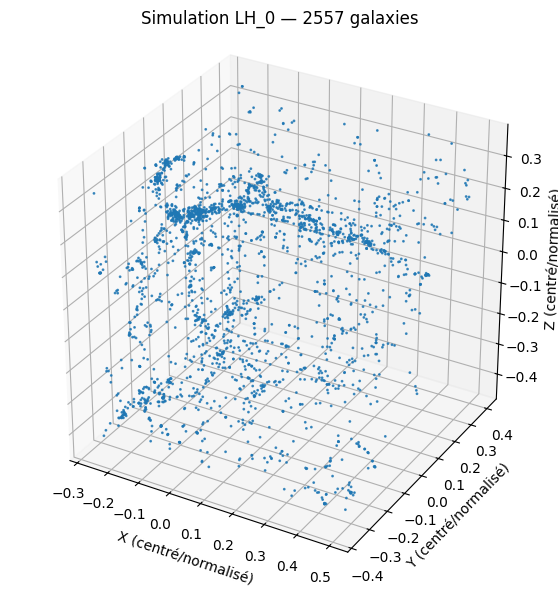

In [10]:
# --- paramètres d'affichage ---
sim_index = 0            # change à volonté (0..599)
max_points = 5000        # sous-échantillonnage max (si None, tout afficher)
color_by = None          # ex: "Mstar" ou "Vmax" pour colorier par une propriété, sinon None

# --- chargement ---
with h5py.File(h5_train, "r") as f:
    sims = sorted(list(f["LH"].keys()), key=lambda s: int(s.split("_")[1]))
    sim_key = sims[sim_index]
    g = f["LH"][sim_key]

    # positions
    X = np.array(g["X"], dtype=np.float32)
    Y = np.array(g["Y"], dtype=np.float32)
    Z = np.array(g["Z"], dtype=np.float32)

    N = X.shape[0]
    idx = np.arange(N)

    # sous-échantillonnage si besoin
    if max_points is not None and N > max_points:
        rng = np.random.default_rng(42)
        idx = rng.choice(N, size=max_points, replace=False)

    x, y, z = X[idx], Y[idx], Z[idx]

    # couleur optionnelle
    c = None
    if color_by is not None and color_by in g:
        c = np.array(g[color_by], dtype=np.float32)[idx]

# --- mise à l'échelle pour axes égaux ---
# on centre et on normalise à [-0.5, 0.5] pour un rendu équilibré
xyz = np.stack([x, y, z], axis=1)
centroid = xyz.mean(axis=0, keepdims=True)
xyz0 = xyz - centroid
L = np.abs(xyz0).max()  # demi-étendue max
if L == 0: L = 1.0
xyzn = xyz0 / (2*L)  # ~ dans [-0.5, 0.5]
x0, y0, z0 = xyzn[:,0], xyzn[:,1], xyzn[:,2]

# --- figure ---
from mpl_toolkits.mplot3d import Axes3D  # nécessaire pour activer le 3D

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# NB: on ne fixe pas de couleur spécifique (contrainte du notebook)
sc = ax.scatter(x0, y0, z0, s=1, alpha=0.8, c=c)

# barre de couleur si on a colorié par une propriété
if c is not None:
    cb = plt.colorbar(sc, ax=ax, pad=0.02, shrink=0.6)
    cb.set_label(color_by)

ax.set_title(f"Simulation {sim_key} — {len(idx)} galaxies")
ax.set_xlabel("X (centré/normalisé)")
ax.set_ylabel("Y (centré/normalisé)")
ax.set_zlabel("Z (centré/normalisé)")

# axes ~égaux
ax.set_box_aspect([1,1,1])

plt.show()

In [11]:
idx = 0  # LH_0
x, y, z = load_position_h5(h5_train, idx=idx, data_name="LH", device="cpu")
x, y, z, vx, vy, vz = load_point_cloud_h5(h5_train, idx=idx, data_name="LH", device="cpu")

print(x.shape, y.shape, z.shape)
print(vx.shape, vy.shape, vz.shape)

torch.Size([2557]) torch.Size([2557]) torch.Size([2557])
torch.Size([2557]) torch.Size([2557]) torch.Size([2557])


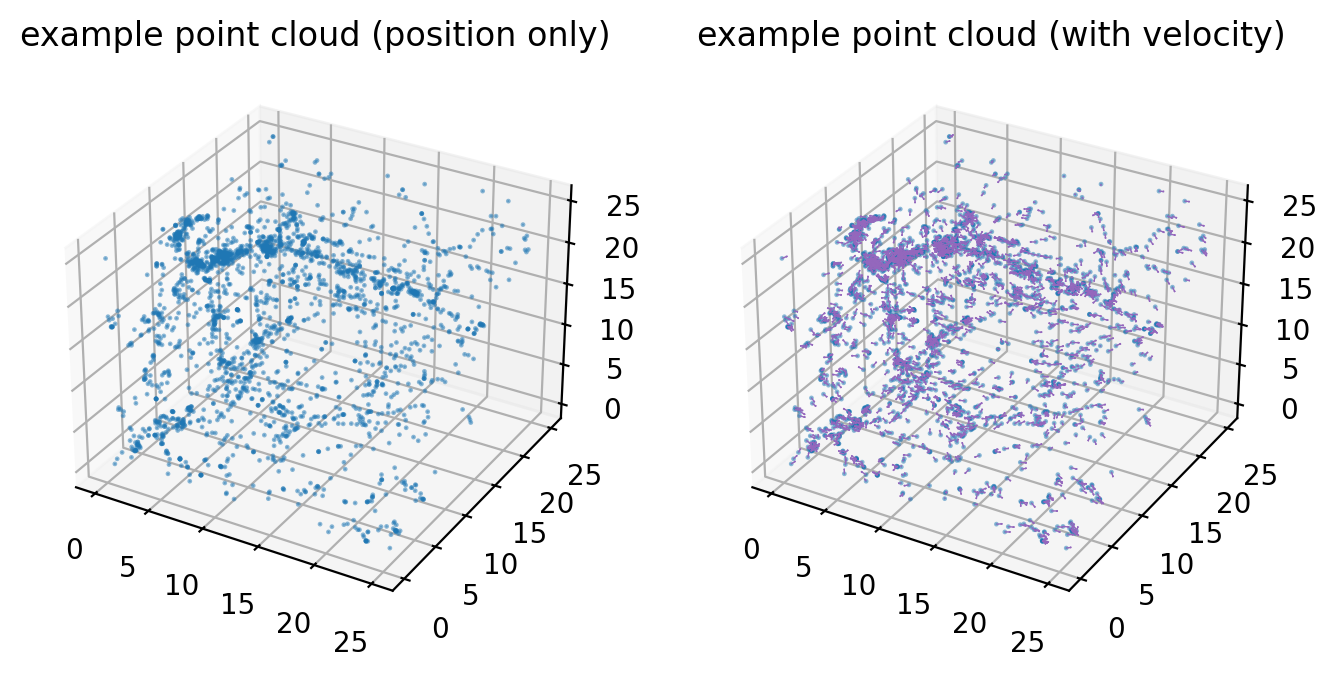

In [12]:
fig = plt.figure(figsize=(8,8), dpi=200)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(x,y,z, color='tab:blue', s=0.5, alpha=0.5)
ax2.scatter(x,y,z, color='tab:blue', s=0.5, alpha=0.5)
ax2.quiver(x,y,z,vx,vy,vz, length=0.5, normalize=True, color='tab:purple', linewidth=0.5)

ax1.set_title('example point cloud (position only)')
ax2.set_title('example point cloud (with velocity)')

plt.show()

### Split dans des frames 2D

In [31]:

def slicing_2D(x, y, z, num_slices=25, slice_thickness=1):
    # Trouver les limites de z
    z_min, z_max = z.min(), z.max()
    slice_centers = np.linspace(z_min, z_max, num_slices)
    
    slices = []
    for center in slice_centers:
        mask = (z >= center - slice_thickness/2) & (z <= center + slice_thickness/2)
        slices.append((x[mask], y[mask]))
    
    return slices

In [32]:
# --- paramètres d'affichage ---
sim_index = 0           # change à volonté (0..599)
color_by = None          # ex: "Mstar" ou "Vmax" pour colorier par une propriété, sinon None

# --- chargement ---
with h5py.File(h5_train, "r") as f:
    sims = sorted(list(f["LH"].keys()), key=lambda s: int(s.split("_")[1]))
    sim_key = sims[sim_index]
    g = f["LH"][sim_key]

    # positions
    X = np.array(g["X"], dtype=np.float32)
    Y = np.array(g["Y"], dtype=np.float32)
    Z = np.array(g["Z"], dtype=np.float32)


We can set the number of slice, here 25, but what is the best configuration.

2557


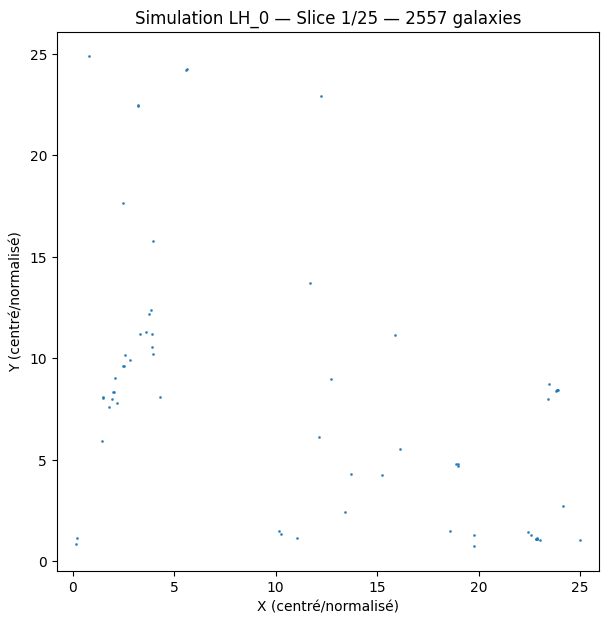

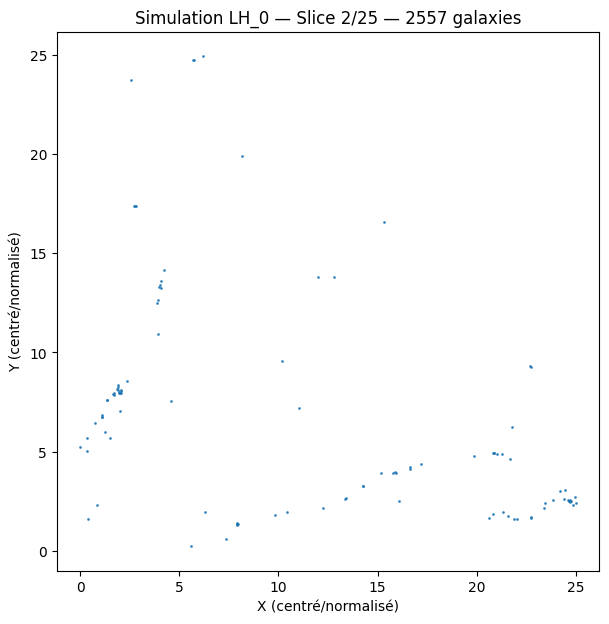

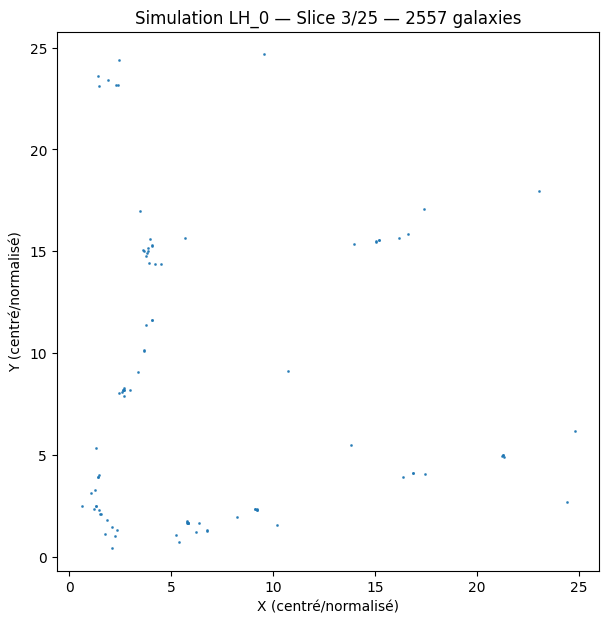

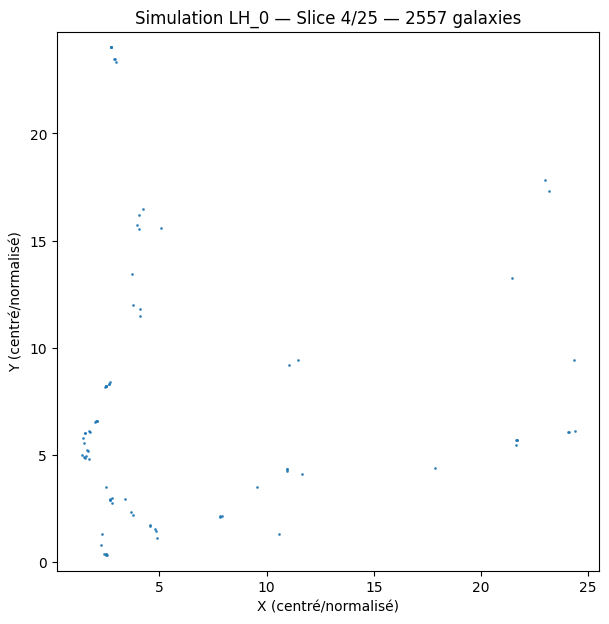

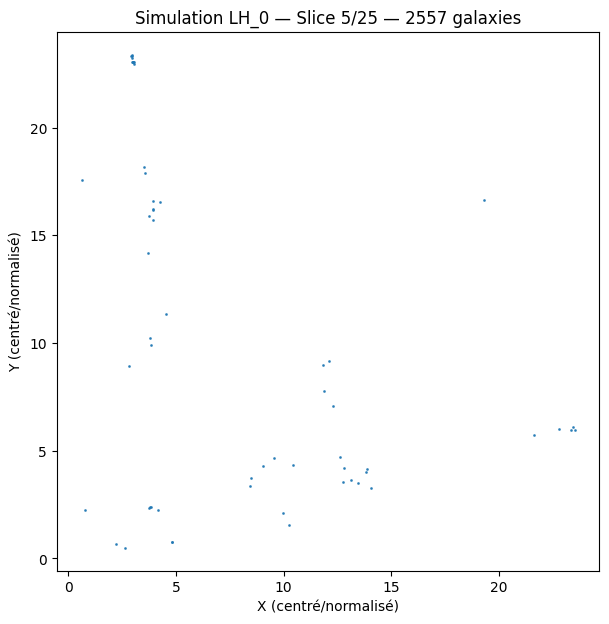

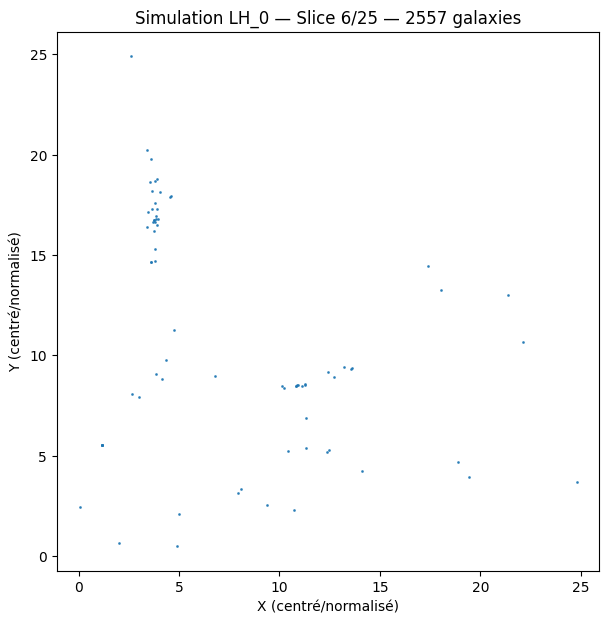

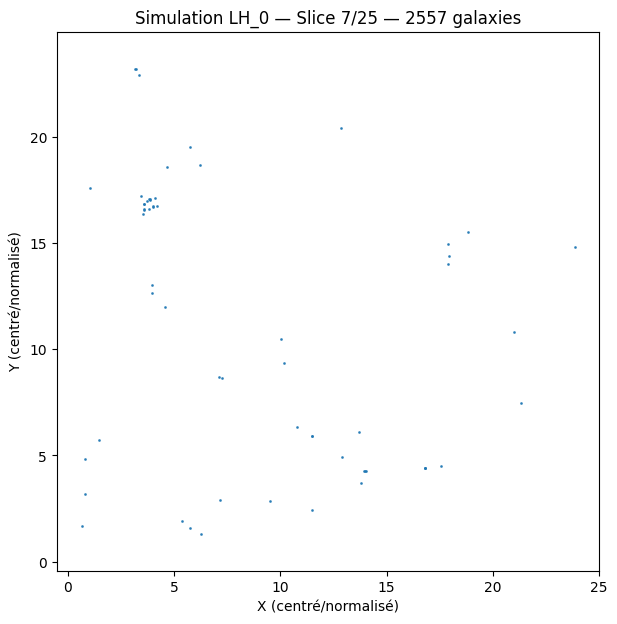

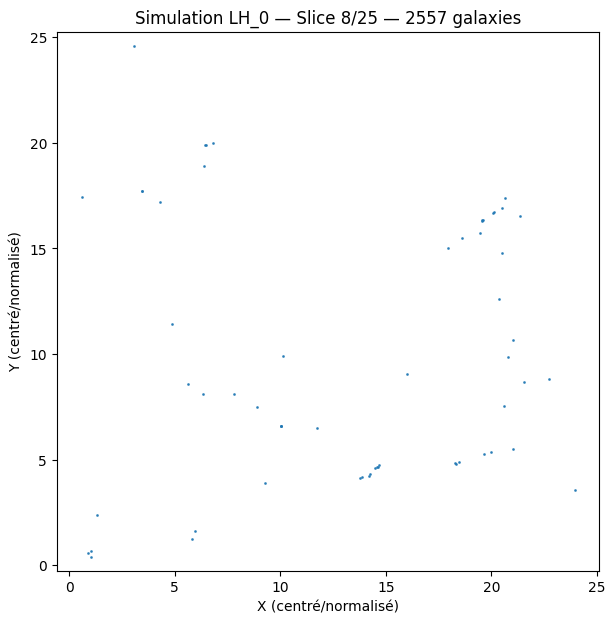

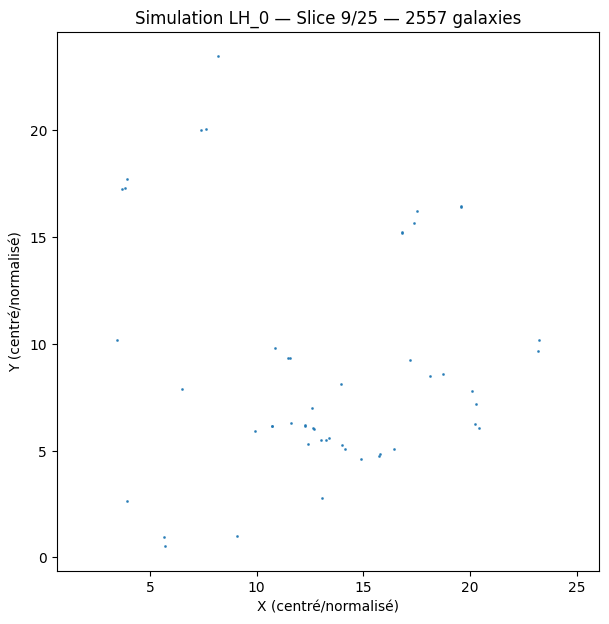

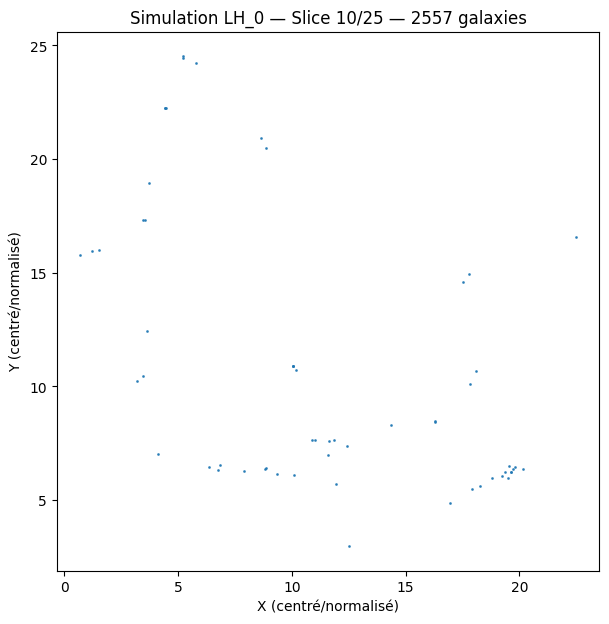

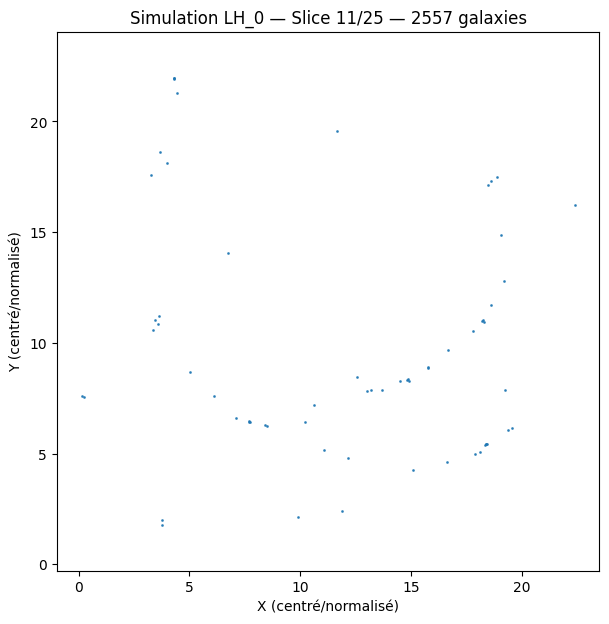

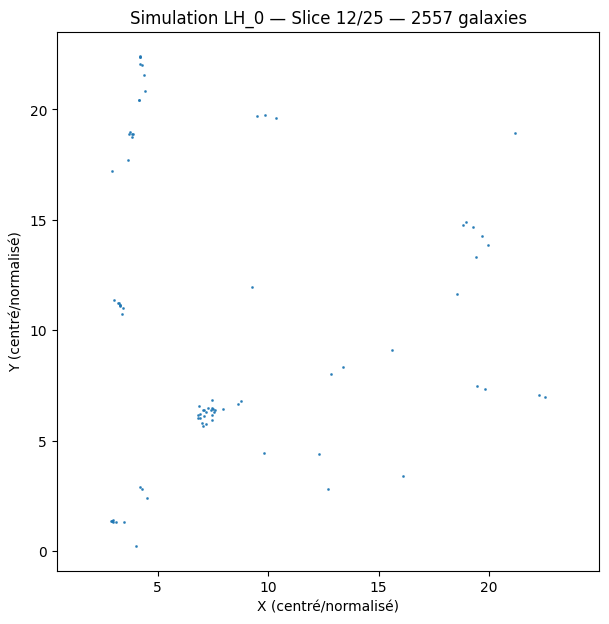

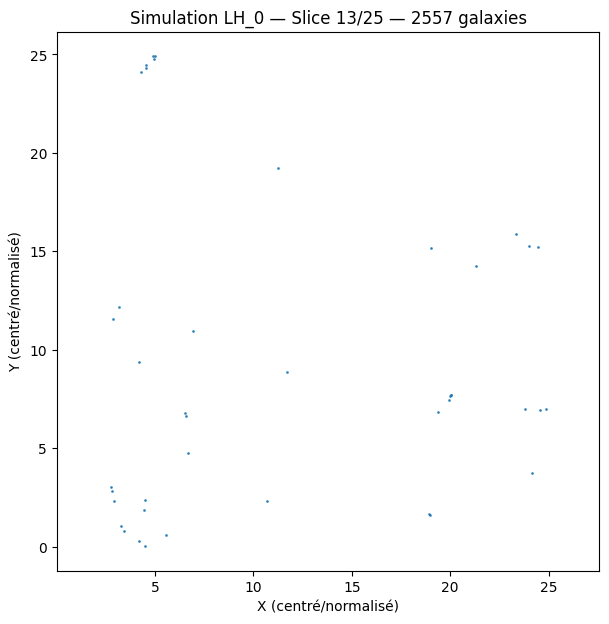

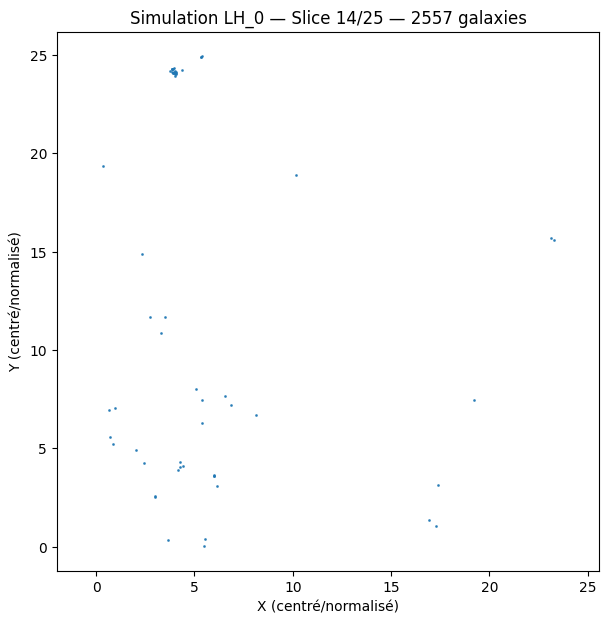

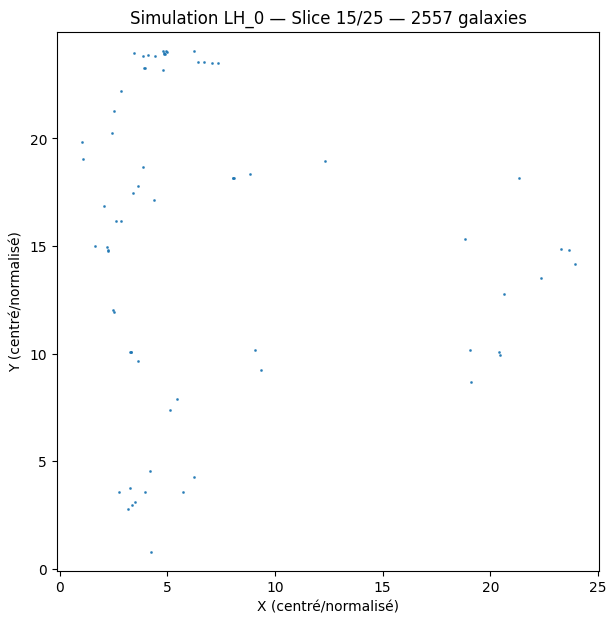

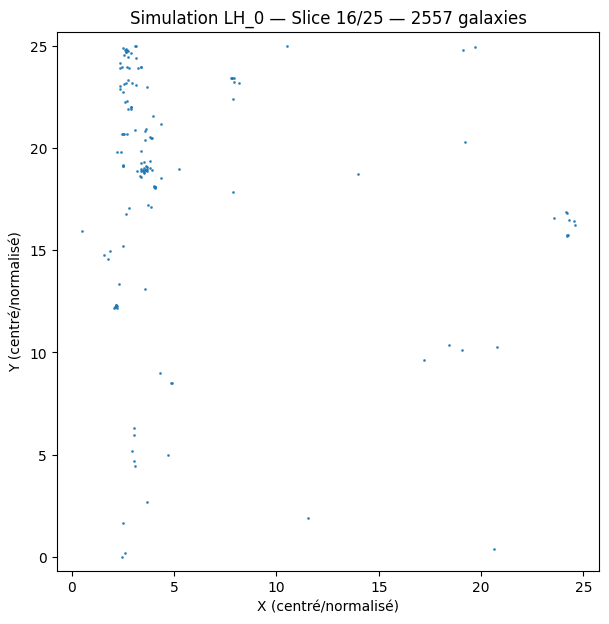

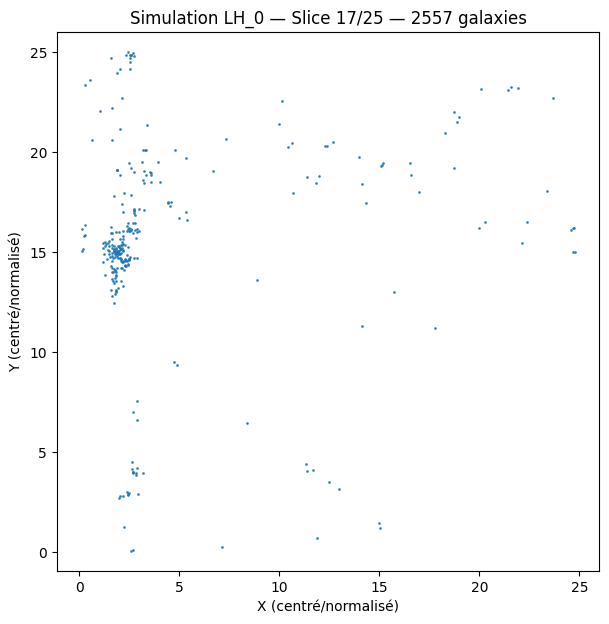

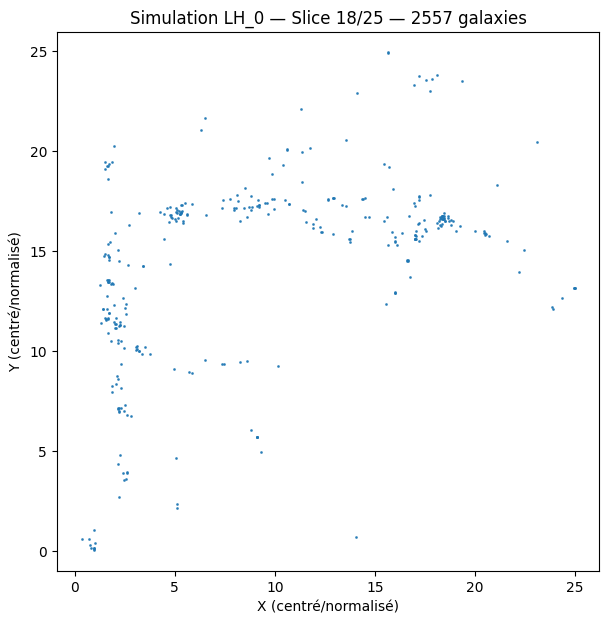

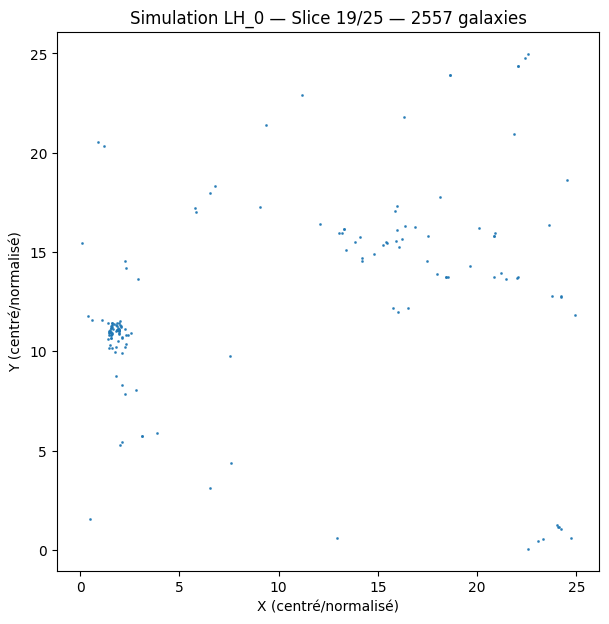

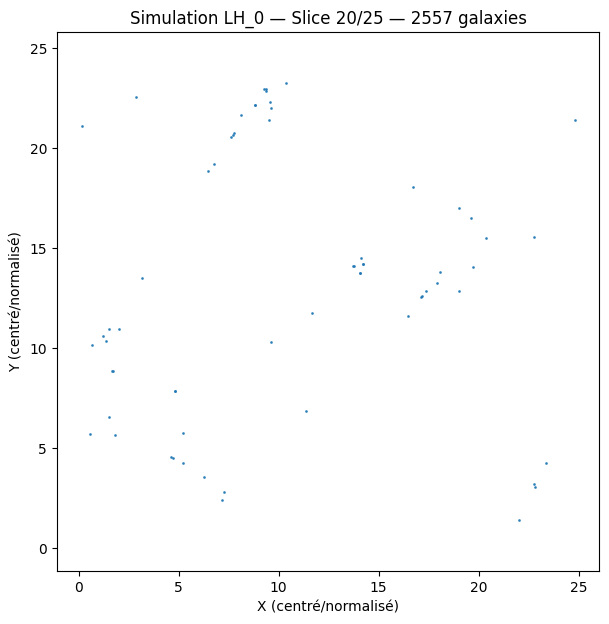

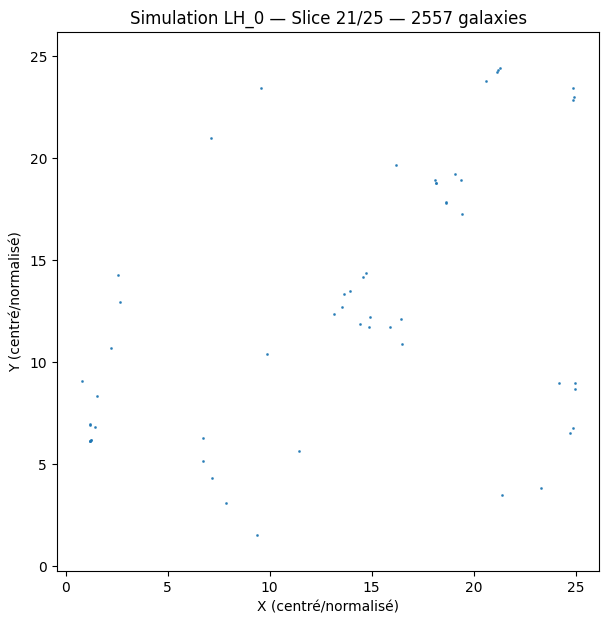

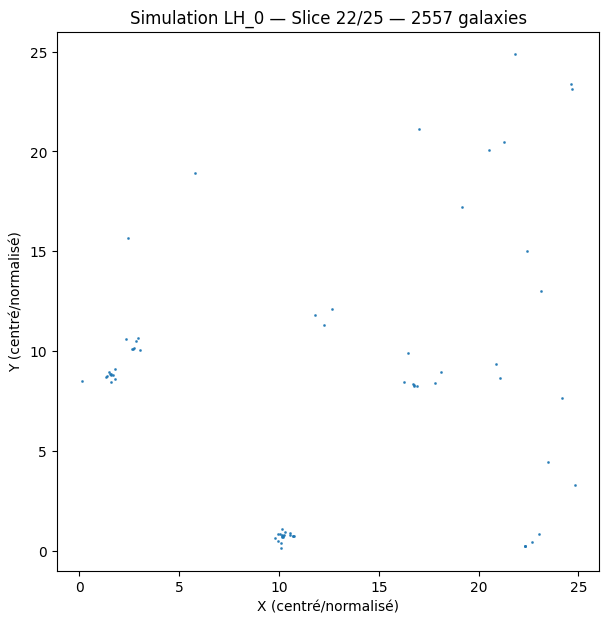

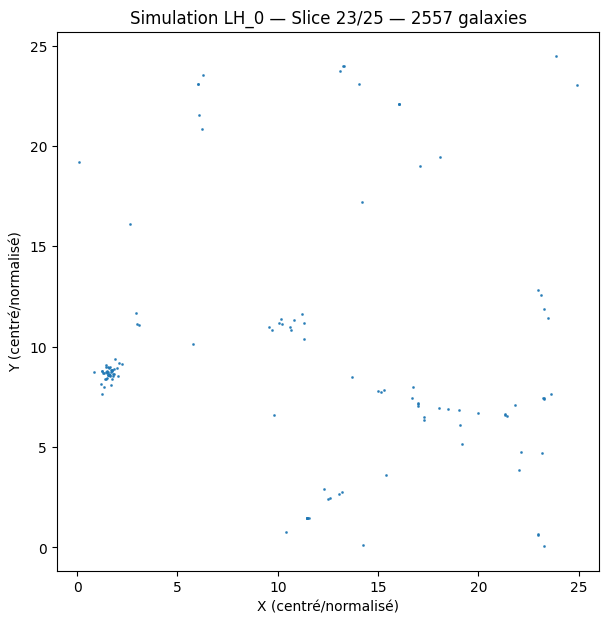

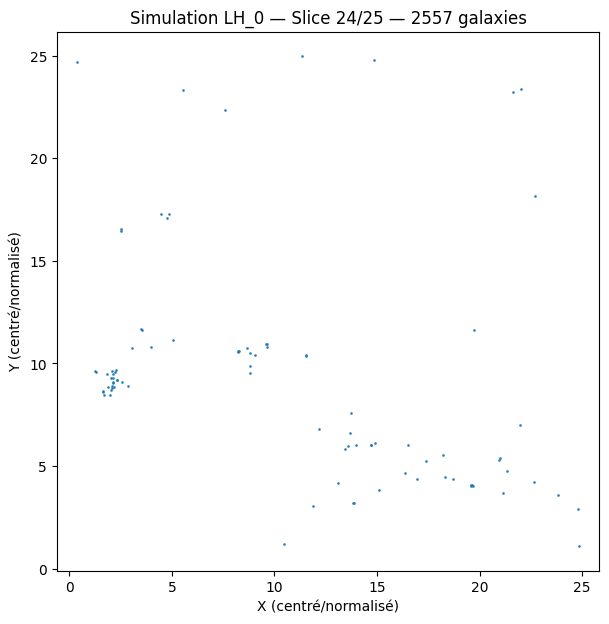

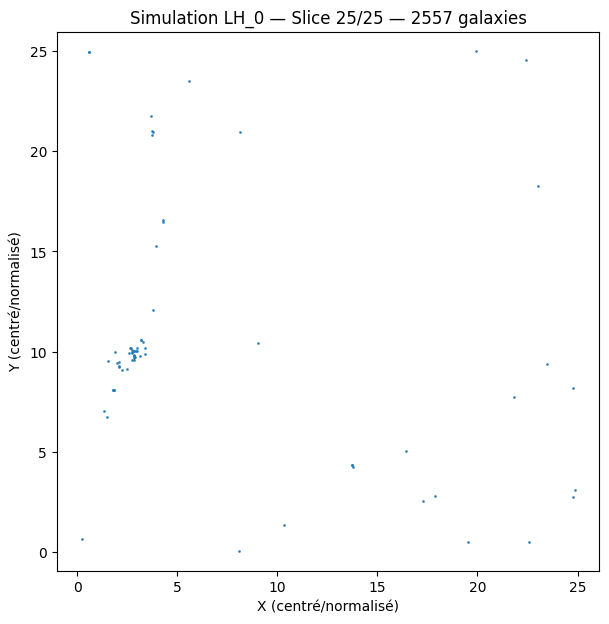

In [33]:
slices = slicing_2D(X, Y, Z, num_slices=25, slice_thickness=1) #adjust to have slice_thickness = 25/num_slices so that all points are included

print(Z.size)
c_slice = None


for i, (x_slice, y_slice) in enumerate(slices):
    
    # we want to plot each slice in 2D
    plt.figure(figsize=(7,7))
    plt.scatter(x_slice, y_slice, s=1, alpha=0.8, c=c_slice)
    plt.title(f"Simulation {sim_key} — Slice {i+1}/{len(slices)} — {len(x0)} galaxies")
    plt.xlabel("X (centré/normalisé)")
    plt.ylabel("Y (centré/normalisé)")
    plt.axis('equal')
    plt.show()

## Getting the data


In [15]:
#our Training set contains 600 simulations with 7 parameters each, and 10 features per galaxy (X,Y,Z,VX,VY,VZ,Mstar,Vmax,Mgas,Metal)
with h5py.File(h5_train, "r") as f:
    # Récupérer les paramètres
    params = f["params"]
    param_names = list(params.keys())
    print("Paramètres disponibles:", param_names)
    
    # Stocker les paramètres dans un dictionnaire
    param_dict = {}
    for name in param_names:
        param_dict[name] = np.array(params[name])
    
    # Afficher la forme des paramètres
    for name, values in param_dict.items():
        print(f"{name}: shape = {values.shape}")


Paramètres disponibles: ['A_AGN1', 'A_AGN2', 'A_SN1', 'A_SN2', 'Omega_m', 'seed', 'sigma_8']
A_AGN1: shape = (600,)
A_AGN2: shape = (600,)
A_SN1: shape = (600,)
A_SN2: shape = (600,)
Omega_m: shape = (600,)
seed: shape = (600,)
sigma_8: shape = (600,)


In [16]:
#from this, we can construct our input X and output Y for our ML model
#X will be the point clouds of the galaxies (positions, velocities, masses and metallicity), and Y will be only 2 of the seven parameters of the simulation (Omega_m, sigma_8) :

feats_wanted = ["X","Y","Z","VX","VY","VZ","Mstar","Vmax","Mgas","Metal_star"]  # adapte si besoin


#load training data
with h5py.File(h5_train, "r") as f:
    sims = sorted(list(f["LH"].keys()), key=lambda s: int(s.split("_")[1]))

    # 1) features présentes dans toutes les sims (intersection)
    common = set(feats_wanted)
    for sk in sims[:20]:  # on échantillonne pour aller vite; enlève [:20] si tu veux être strict
        common &= set(f["LH"][sk].keys())
    feats = [k for k in feats_wanted if k in common]
    print("Features utilisées:", feats)

    # 2) récupérer Y (2 paramètres)
    param_names = ["Omega_m", "sigma_8"]
    param_arrays = [np.array(f["params"][name]) for name in param_names]
    Y_train = np.stack(param_arrays, axis=-1).astype(np.float32)   # (N_sims, 7)
    print("Y shape:", Y.shape)

    # 3) construire une liste ragged de features
    X_train = []
    lengths = []
    for sk in sims:
        g = f["LH"][sk]
        arrs = [np.array(g[k]) for k in feats]
        X_sim = np.stack(arrs, axis=-1).astype(np.float32)   # (N_gal_i, F)
        X_train.append(X_sim)
        lengths.append(X_sim.shape[0])

    lengths = np.array(lengths)
    print("N_gal min/max/median:", lengths.min(), lengths.max(), int(np.median(lengths)))




Features utilisées: ['X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'Mstar', 'Vmax', 'Mgas', 'Metal_star']
Y shape: (2557,)
N_gal min/max/median: 588 4451 2338


In [17]:
#load validation data
with h5py.File(h5_val, "r") as f:
    sims_val = sorted(list(f["LH"].keys()), key=lambda s: int(s.split("_")[1]))
    
    # Get Y_val (Omega_m, sigma_8)
    param_names = ["Omega_m", "sigma_8"]
    param_arrays_val = [np.array(f["params"][name]) for name in param_names]
    Y_val = np.stack(param_arrays_val, axis=-1).astype(np.float32)
    print(f"Y_val shape: {Y_val.shape}")
    
    # Get X_val (ragged point clouds)
    X_val = []
    for sk in sims_val:
        g = f["LH"][sk]
        arrs = [np.array(g[k]) for k in feats]
        X_sim = np.stack(arrs, axis=-1).astype(np.float32)
        X_val.append(X_sim)

print(f"X_val: {len(X_val)} simulations loaded")

Y_val shape: (200, 2)
X_val: 200 simulations loaded


In [18]:
# Load test set (
print("Loading test set...")
with h5py.File(h5_test, "r") as f:
    sims_test = sorted(list(f["LH"].keys()), key=lambda s: int(s.split("_")[1]))
    
    param_arrays_test = [np.array(f["params"][name]) for name in param_names]
    Y_test = np.stack(param_arrays_test, axis=-1).astype(np.float32)
    
    X_test = []
    for sk in sims_test:
        g = f["LH"][sk]
        arrs = [np.array(g[k]) for k in feats]
        X_sim = np.stack(arrs, axis=-1).astype(np.float32)
        X_test.append(X_sim)

print(f"X_test: {len(X_test)} simulations loaded")

Loading test set...
X_test: 200 simulations loaded


In [19]:
# What is the shape/size of X_list and Y?
print(f"Number of simulations (X_train): {len(X_train)}")
print(f"Shape of Y_train: {Y_train.shape}")
#for i, X_sim in enumerate(X_train):
#    print(f"Simulation {i}: shape = {X_sim.shape}")

Number of simulations (X_train): 600
Shape of Y_train: (600, 2)


In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from scipy.ndimage import gaussian_filter

def point_clouds_to_multichannel_grids(X_train, grid_size=32, n_angles=6):
    """
    X_train: list of (N_gal_i, n_feat) arrays
    Returns: (n_sims, n_feat * n_angles, grid_size, grid_size)
    Each feature gets its own grid at each angle.
    """
    grids_list = []
    n_feat = X_train[0].shape[1]
    
    for X_sim in X_train:
        xyz = X_sim[:, :3]  # X, Y, Z
        other_feats = X_sim[:, 3:]  # remaining 7 features
        
        # Center and scale positions
        centroid = xyz.mean(axis=0)
        xyz_c = xyz - centroid
        L = np.abs(xyz_c).max()
        if L == 0: L = 1.0
        xyz_scaled = xyz_c / (2*L)
        
        xr, yr = xyz_scaled[:,0], xyz_scaled[:,1]
        r = max(np.abs(xr).max(), np.abs(yr).max()) + 0.1
        
        sim_grids = []
        angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)
        
        for angle in angles:
            c, s = np.cos(angle), np.sin(angle)
            xrot = c*xr - s*yr
            yrot = s*xr + c*yr
            
            # Create grid for each of 10 features
            for feat_idx in range(n_feat):
                if feat_idx < 3:
                    # Position features: already rotated
                    if feat_idx == 0:
                        vals = xrot
                    elif feat_idx == 1:
                        vals = yrot
                    else:
                        vals = xyz_scaled[:,2]
                else:
                    # Other features: use unrotated positions
                    vals = other_feats[:, feat_idx-3]
                
                H, _, _ = np.histogram2d(xrot, yrot, bins=grid_size, range=[[-r,r],[-r,r]], 
                                        weights=vals)
                # Normalize by count to get mean value per bin
                counts, _, _ = np.histogram2d(xrot, yrot, bins=grid_size, range=[[-r,r],[-r,r]])
                H = np.divide(H, counts, where=counts>0, out=np.zeros_like(H))
                
                H = np.log1p(np.abs(H))
                H = gaussian_filter(H, sigma=0.5)
                sim_grids.append(H.astype(np.float32))
        
        grids_list.append(np.stack(sim_grids, axis=0))
    
    return np.array(grids_list)  # (n_sims, n_feat*n_angles, grid, grid)


In [21]:
print("Converting to multi-channel grids (10 features × 6 angles)...")
X_train_grids = point_clouds_to_multichannel_grids(X_train, grid_size=32, n_angles=6)
print(f"X_train_grids shape: {X_train_grids.shape}")  # (600, 60, 32, 32)


Converting to multi-channel grids (10 features × 6 angles)...
X_train_grids shape: (600, 60, 32, 32)


In [22]:
# Convert validation set to grids
print("Converting validation set to multi-channel grids...")
X_val_grids = point_clouds_to_multichannel_grids(X_val, grid_size=32, n_angles=6)
print(f"X_val_grids shape: {X_val_grids.shape}")

Converting validation set to multi-channel grids...
X_val_grids shape: (200, 60, 32, 32)


In [23]:
print("Converting test set to multi-channel grids...")
X_test_grids = point_clouds_to_multichannel_grids(X_test, grid_size=32, n_angles=6)
print(f"X_test_grids shape: {X_test_grids.shape}")

Converting test set to multi-channel grids...
X_test_grids shape: (200, 60, 32, 32)


### Linear Regression


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# === Aggregate statistics for linear regression ===
def aggregate_features(X_list):
    """
    Compute mean, std, min, max for each feature per simulation.
    X_list: list of (N_gal_i, n_feat) arrays
    Returns: (N_sims, n_feat * 4) array
    """
    n_sims = len(X_list)
    n_feats = X_list[0].shape[1]
    agg = []
    
    for X_sim in X_list:
        row = []
        for feat_idx in range(n_feats):
            col = X_sim[:, feat_idx]
            row.extend([col.mean(), col.std(), col.min(), col.max()])
        agg.append(row)
    
    return np.array(agg, dtype=np.float32)


In [25]:
# Aggregate all three sets
print("Aggregating features...")
X_train_agg = aggregate_features(X_train)
X_val_agg = aggregate_features(X_val)
X_test_agg = aggregate_features(X_test)

print(f"X_train_agg shape: {X_train_agg.shape}")  # (600, n_feats*4)
print(f"X_val_agg shape: {X_val_agg.shape}")
print(f"X_test_agg shape: {X_test_agg.shape}")

Aggregating features...
X_train_agg shape: (600, 40)
X_val_agg shape: (200, 40)
X_test_agg shape: (200, 40)


In [26]:
# === Train linear regression ===
print("\nTraining linear regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_agg, Y_train)

# Predictions
y_pred_train_lr = lr_model.predict(X_train_agg)
y_pred_val_lr = lr_model.predict(X_val_agg)
y_pred_test_lr = lr_model.predict(X_test_agg)



Training linear regression...


In [27]:
# Evaluation
print("\n=== Linear Regression Results ===")
print("TRAIN:")
print(f"  RMSE: {np.sqrt(mean_squared_error(Y_train, y_pred_train_lr)):.6f}")
print(f"  R²:   {r2_score(Y_train, y_pred_train_lr):.6f}")

print("VALIDATION:")
print(f"  RMSE: {np.sqrt(mean_squared_error(Y_val, y_pred_val_lr)):.6f}")
print(f"  R²:   {r2_score(Y_val, y_pred_val_lr):.6f}")

print("TEST:")
print(f"  RMSE: {np.sqrt(mean_squared_error(Y_test, y_pred_test_lr)):.6f}")
print(f"  R²:   {r2_score(Y_test, y_pred_test_lr):.6f}")



=== Linear Regression Results ===
TRAIN:
  RMSE: 0.092197
  R²:   0.364896
VALIDATION:
  RMSE: 0.097035
  R²:   0.295400
TEST:
  RMSE: 0.097659
  R²:   0.269980


### Random Forest ???

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

RF = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
RF.fit(X_train_agg, Y_train)


# Make predictions
y_pred_train_rf = RF.predict(X_train_agg)
y_pred_val_rf = RF.predict(X_val_agg)
y_pred_test_rf = RF.predict(X_test_agg)

In [29]:
# Evaluate properly
print("\n=== Random Forest Results ===")
print("TRAIN:")
print(f"  RMSE: {np.sqrt(mean_squared_error(Y_train, y_pred_train_rf)):.6f}")
print(f"  R²:   {r2_score(Y_train, y_pred_train_rf):.6f}")

print("VALIDATION:")
print(f"  RMSE: {np.sqrt(mean_squared_error(Y_val, y_pred_val_rf)):.6f}")
print(f"  R²:   {r2_score(Y_val, y_pred_val_rf):.6f}")

print("TEST:")
print(f"  RMSE: {np.sqrt(mean_squared_error(Y_test, y_pred_test_rf)):.6f}")
print(f"  R²:   {r2_score(Y_test, y_pred_test_rf):.6f}")


=== Random Forest Results ===
TRAIN:
  RMSE: 0.024238
  R²:   0.956023
VALIDATION:
  RMSE: 0.067332
  R²:   0.658845
TEST:
  RMSE: 0.064483
  R²:   0.685130


In [30]:
# Evaluate properly
print("\n=== Random Forest Results ===")
print("TRAIN:")
print(f"  RMSE: {np.sqrt(mean_squared_error(Y_train, y_pred_train_rf)):.6f}")
print(f"  R²:   {r2_score(Y_train, y_pred_train_rf):.6f}")

print("VALIDATION:")
print(f"  RMSE: {np.sqrt(mean_squared_error(Y_val, y_pred_val_rf)):.6f}")
print(f"  R²:   {r2_score(Y_val, y_pred_val_rf):.6f}")

print("TEST:")
print(f"  RMSE: {np.sqrt(mean_squared_error(Y_test, y_pred_test_rf)):.6f}")
print(f"  R²:   {r2_score(Y_test, y_pred_test_rf):.6f}")


=== Random Forest Results ===
TRAIN:
  RMSE: 0.024238
  R²:   0.956023
VALIDATION:
  RMSE: 0.067332
  R²:   0.658845
TEST:
  RMSE: 0.064483
  R²:   0.685130


### CNN


In [ ]:
# === Prepare Data for CNN ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Normalize grids using training set statistics
train_mean = X_train_grids.mean()
train_std = X_train_grids.std()

X_train_norm = (X_train_grids - train_mean) / (train_std + 1e-8)
X_val_norm = (X_val_grids - train_mean) / (train_std + 1e-8)
X_test_norm = (X_test_grids - train_mean) / (train_std + 1e-8)

# Convert to PyTorch tensors
X_train_t = torch.from_numpy(X_train_norm).float()
Y_train_t = torch.from_numpy(Y_train).float()

X_val_t = torch.from_numpy(X_val_norm).float()
Y_val_t = torch.from_numpy(Y_val).float()

X_test_t = torch.from_numpy(X_test_norm).float()
Y_test_t = torch.from_numpy(Y_test).float()

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, Y_val_t), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, Y_test_t), batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

Train batches: 38, Val batches: 13, Test batches: 13


In [ ]:
# === Improved CNN Model ===
class ImprovedCosmoCNN(nn.Module):
    def __init__(self, n_channels=60, n_outputs=2):
        super(ImprovedCosmoCNN, self).__init__()
        
        # Smaller, better regularized model
        self.conv1 = nn.Conv2d(n_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)  # 32 -> 16 -> 8 -> 4
        
        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # FC layers
        self.fc1 = nn.Linear(128, 64)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, n_outputs)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ImprovedCosmoCNN(n_channels=60, n_outputs=2).to(device)
print(model)

Using device: cpu
ImprovedCosmoCNN(
  (conv1): Conv2d(60, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)

In [ ]:
# === Training Loop ===
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

epochs = 100
patience = 25
best_val_loss = float('inf')
patience_counter = 0

train_losses, val_losses = [], []

print("\nStarting training...")
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, Y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, Y_batch)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_cnn_model.pt')
    else:
        patience_counter += 1
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

print("Training complete!")

# Load best model
model.load_state_dict(torch.load('best_cnn_model.pt'))


Starting training...
Epoch 20/100 - Train Loss: 0.025932, Val Loss: 0.006675
Epoch 40/100 - Train Loss: 0.019453, Val Loss: 0.008907
Epoch 60/100 - Train Loss: 0.017247, Val Loss: 0.008709
Epoch 80/100 - Train Loss: 0.014756, Val Loss: 0.006678
Early stopping at epoch 81
Training complete!


<All keys matched successfully>

In [ ]:
# === Evaluation ===
model.eval()
y_pred_train_cnn = []
y_pred_val_cnn = []
y_pred_test_cnn = []

with torch.no_grad():
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch).cpu().numpy()
        y_pred_train_cnn.append(y_pred)
    
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch).cpu().numpy()
        y_pred_val_cnn.append(y_pred)
    
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch).cpu().numpy()
        y_pred_test_cnn.append(y_pred)

y_pred_train_cnn = np.vstack(y_pred_train_cnn)
y_pred_val_cnn = np.vstack(y_pred_val_cnn)
y_pred_test_cnn = np.vstack(y_pred_test_cnn)

# Results
print("\n=== CNN Results ===")
print("TRAIN:")
print(f"  RMSE: {np.sqrt(mean_squared_error(Y_train, y_pred_train_cnn)):.6f}")
print(f"  R²:   {r2_score(Y_train, y_pred_train_cnn):.6f}")

print("VALIDATION:")
print(f"  RMSE: {np.sqrt(mean_squared_error(Y_val, y_pred_val_cnn)):.6f}")
print(f"  R²:   {r2_score(Y_val, y_pred_val_cnn):.6f}")

print("TEST:")
print(f"  RMSE: {np.sqrt(mean_squared_error(Y_test, y_pred_test_cnn)):.6f}")
print(f"  R²:   {r2_score(Y_test, y_pred_test_cnn):.6f}")

# Comparison
print(f"\n=== COMPARISON ===")
print(f"Linear Regression - Test R²: {r2_score(Y_test, y_pred_test_lr):.6f}")
print(f"CNN - Test R²: {r2_score(Y_test, y_pred_test_cnn):.6f}")


=== CNN Results ===
TRAIN:
  RMSE: 0.141161
  R²:   -0.488644
VALIDATION:
  RMSE: 0.076711
  R²:   0.557450
TEST:
  RMSE: 0.074925
  R²:   0.574113

=== COMPARISON ===
Linear Regression - Test R²: 0.269980
CNN - Test R²: 0.574113
